# EOC Signal Extraction
---

In [1]:
%%time
import glob, datetime, warnings, utm, mcaap, sys
sys.path.append('/Users/mronacgiannone/Documents/Cardinal')
import cardinal
#-----------------------------------------------------------------------------------------------------------------#
# Command to make all plots interactive
%matplotlib ipympl

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from obspy import *
from obspy.core import *
from scipy import signal
from pyproj import Geod; g = Geod(ellps='sphere')

warnings.filterwarnings('ignore')

# Global variables where data are stored
EOC_dir = '/Volumes/Extreme SSD/McAAP/Winter_2021/'

CPU times: user 3.39 s, sys: 5.26 s, total: 8.64 s
Wall time: 4.1 s


## EOCR Array Processing
---

In [2]:
# Constructing frequency bands for Cardinal
f_bands = cardinal.make_custom_fbands(f_min=1, f_max=20.5, win_max=5, type='third_octave')
f_bands['fmax'].values[-1] = np.round(f_bands['fmax'].values[-1],0) # rounding so f_max becomes Nyquist
f_bands

band       fmin    fcenter       fmax       win      step
0    1.0   1.000000   1.129961   1.259921  4.758177  0.475818
1    2.0   1.259921   1.423661   1.587401  4.374307  0.437431
2    3.0   1.587401   1.793701   2.000000  4.069629  0.406963
3    4.0   2.000000   2.259921   2.519842  3.827806  0.382781
4    5.0   2.519842   2.847322   3.174802  3.635872  0.363587
5    6.0   3.174802   3.587401   4.000000  3.483533  0.348353
6    7.0   4.000000   4.519842   5.039684  3.362621  0.336262
7    8.0   5.039684   5.694644   6.349604  3.266654  0.326665
8    9.0   6.349604   7.174802   8.000000  3.190484  0.319048
9   10.0   8.000000   9.039684  10.079368  3.130029  0.313003
10  11.0  10.079368  11.389288  12.699208  3.082045  0.308204
11  12.0  12.699208  14.349604  16.000000  3.043960  0.304396
12  13.0  16.000000  18.079368  20.000000  3.013732  0.301373

CPU times: user 31.4 s, sys: 11.5 s, total: 43 s
Wall time: 1min 35s


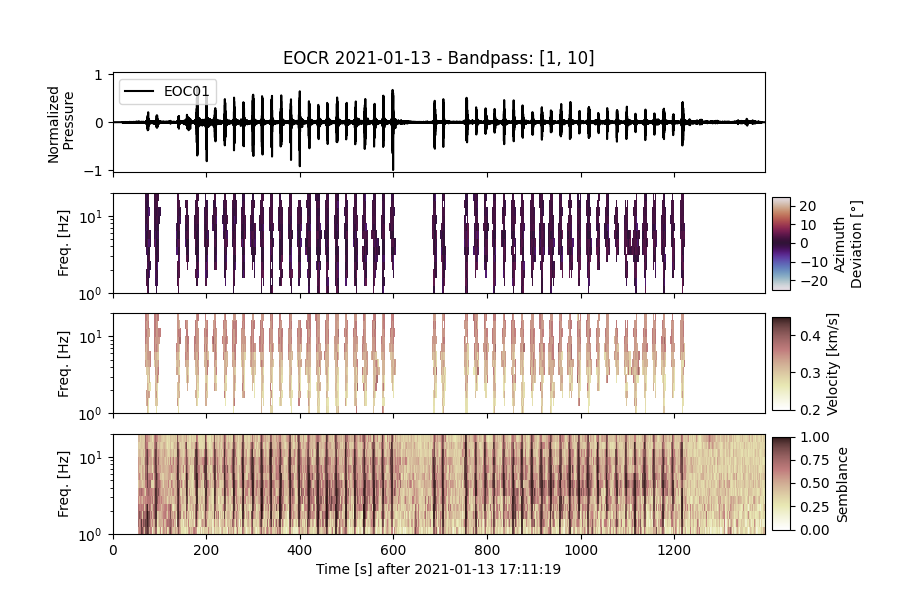

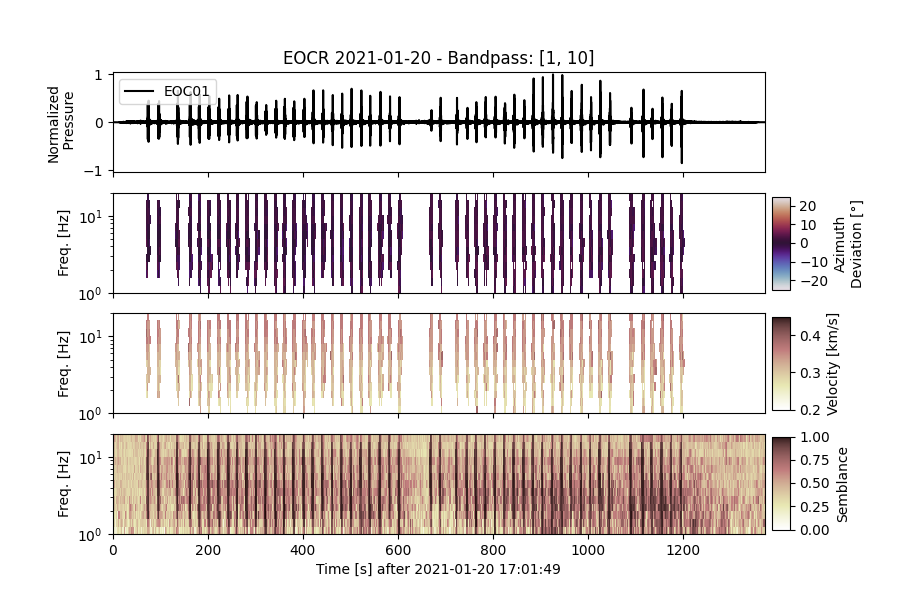

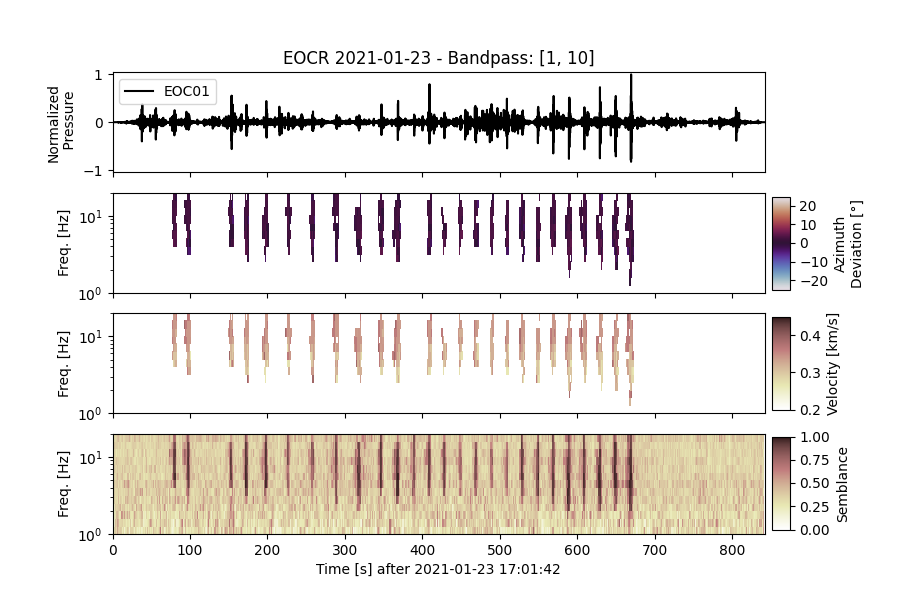

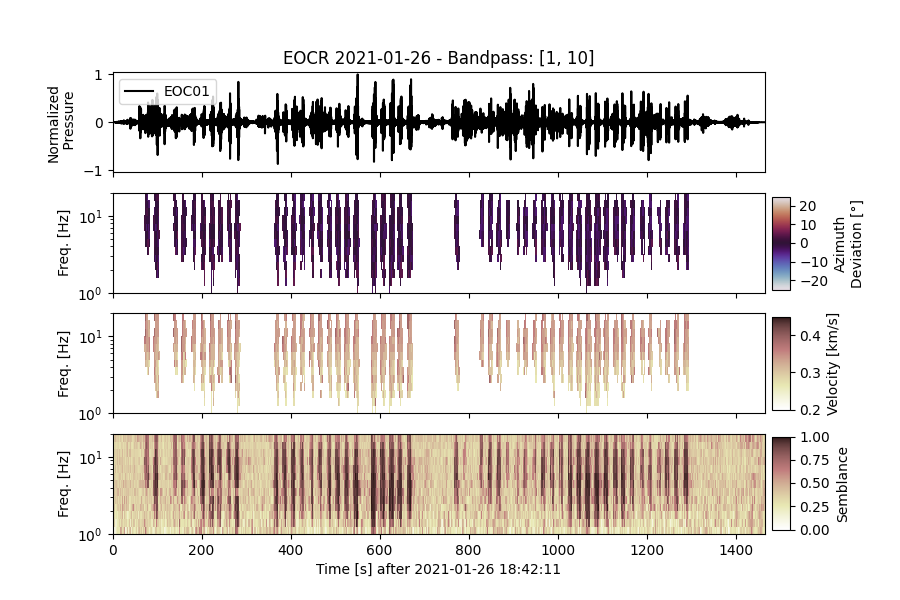

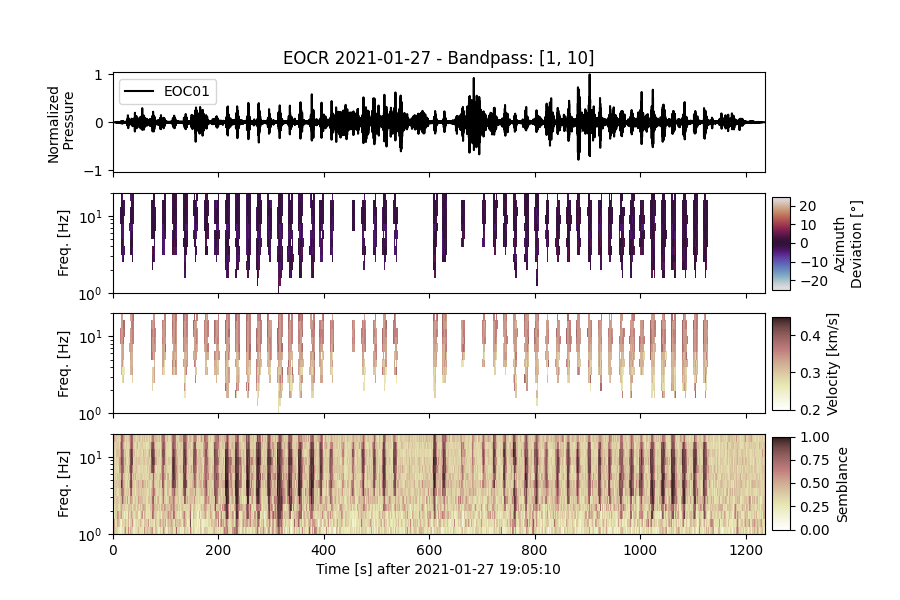

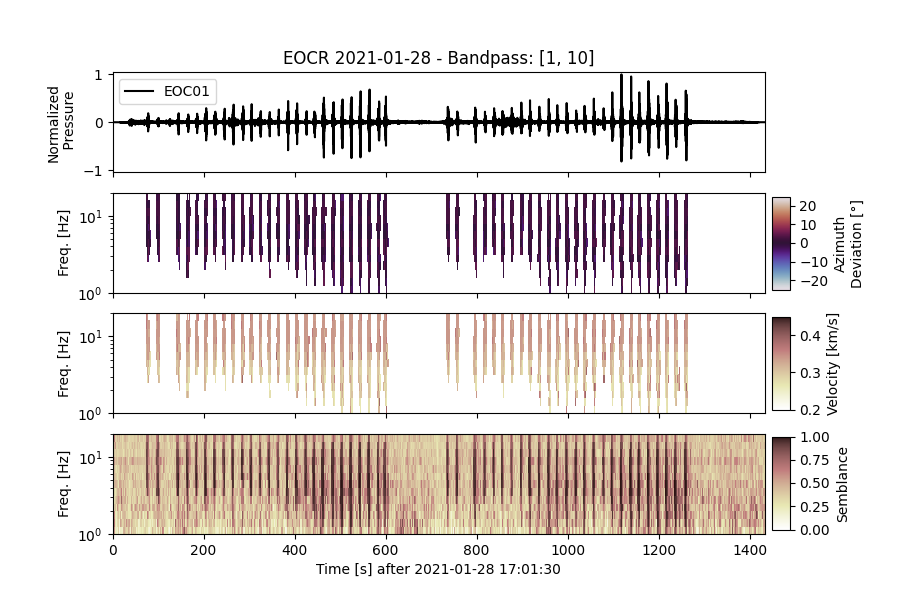

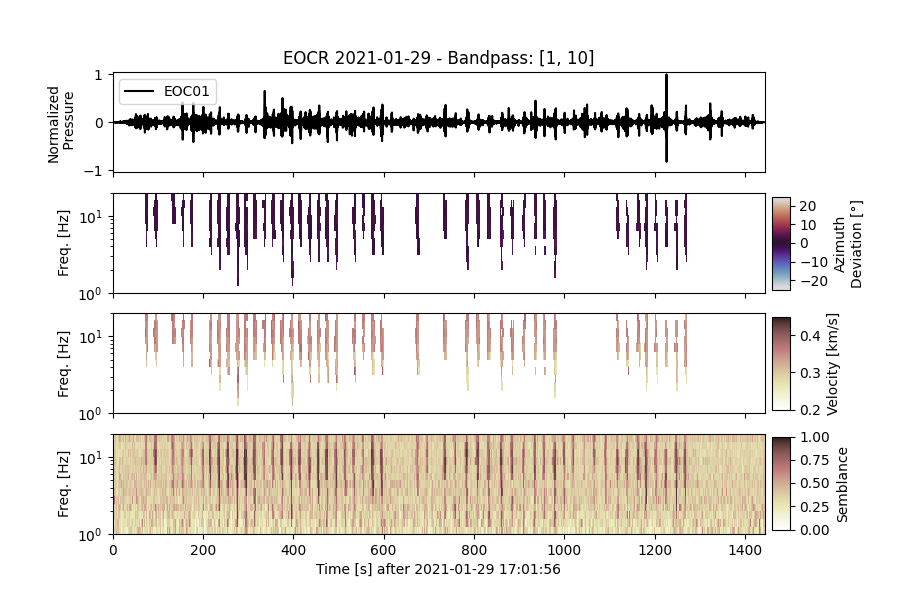

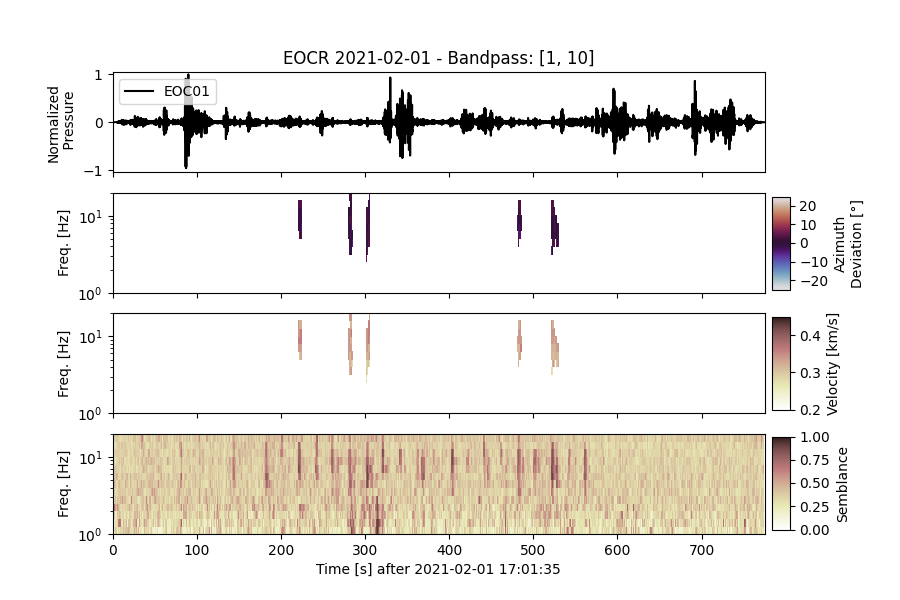

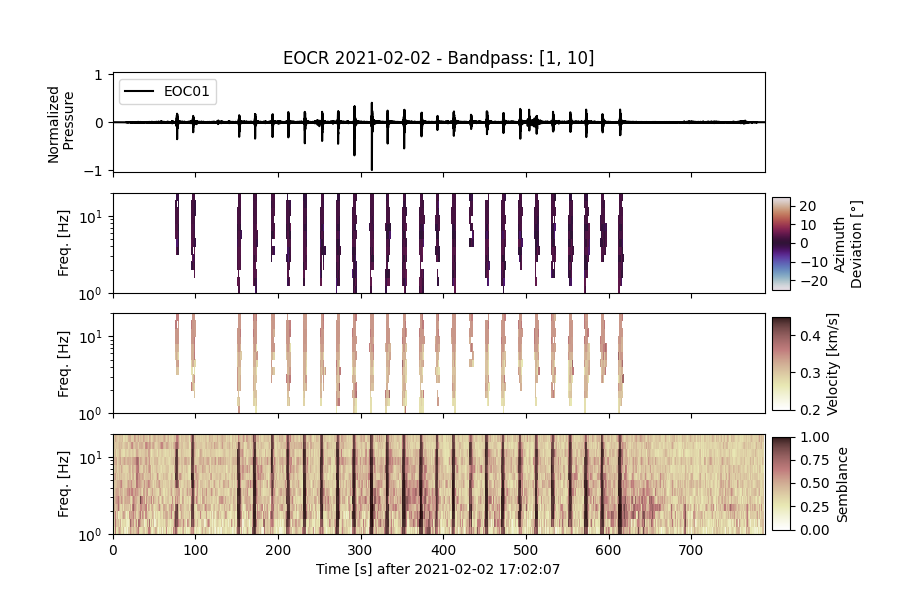

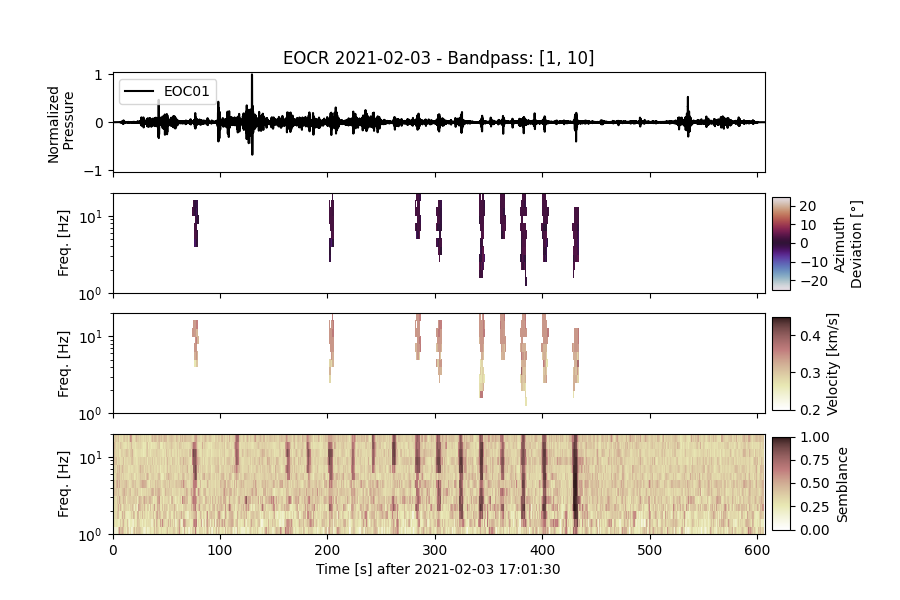

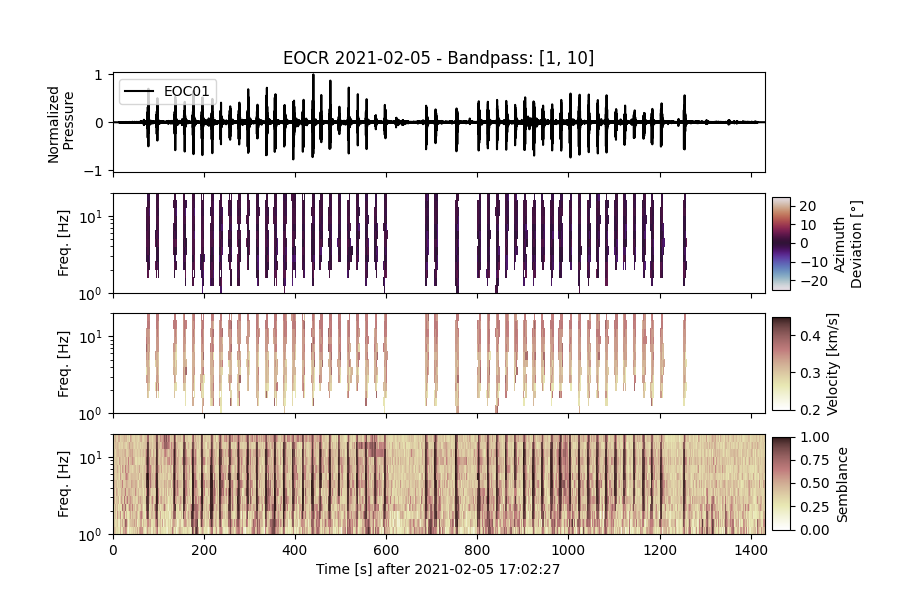

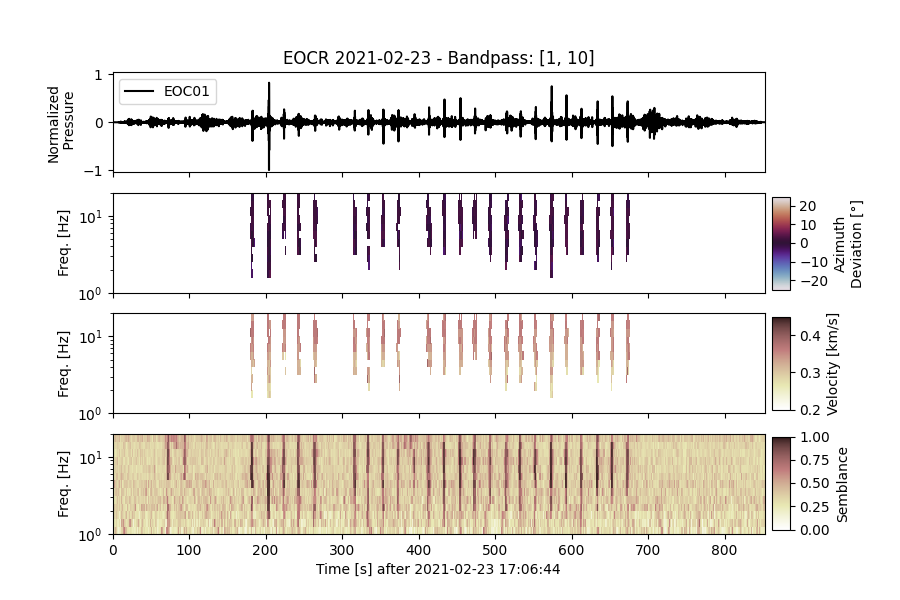

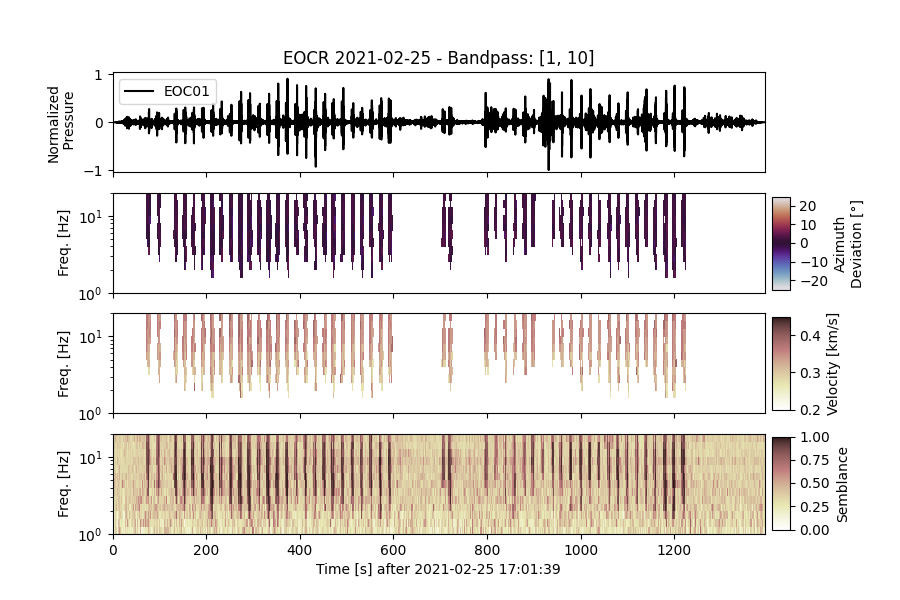

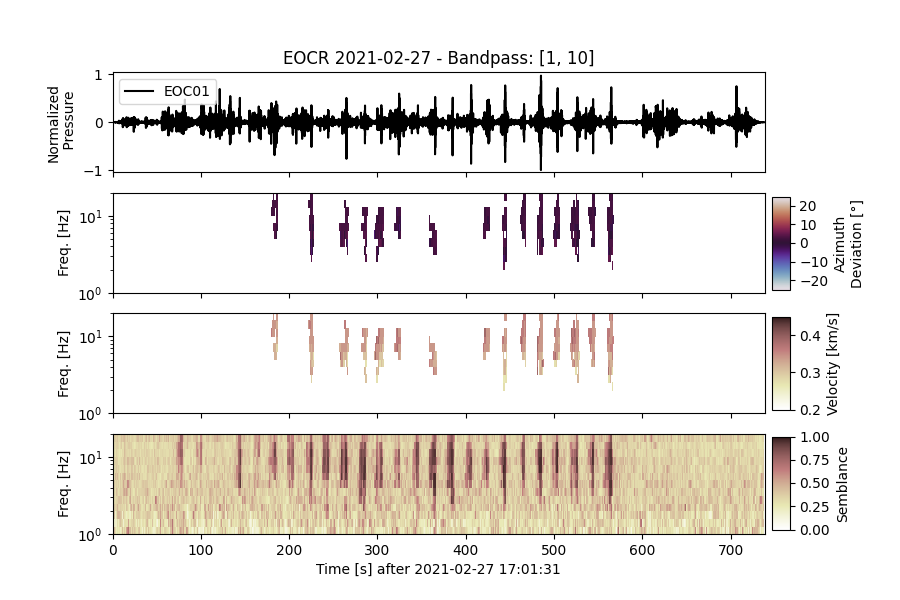

2025-11-04 12:48:44,452 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 11 memory: 82 MB fds: 359>>
Traceback (most recent call last):
  File "/Users/mronacgiannone/anaconda3/envs/deep_learning/lib/python3.10/site-packages/tornado/ioloop.py", line 937, in _run
    val = self.callback()
  File "/Users/mronacgiannone/anaconda3/envs/deep_learning/lib/python3.10/site-packages/distributed/system_monitor.py", line 168, in update
    net_ioc = psutil.net_io_counters()
  File "/Users/mronacgiannone/anaconda3/envs/deep_learning/lib/python3.10/site-packages/psutil/__init__.py", line 2160, in net_io_counters
    rawdict = _psplatform.net_io_counters()
OSError: [Errno 12] Cannot allocate memory


In [5]:
%%time
from dask.distributed import Client
n_workers = 4; client = Client(threads_per_worker=1, n_workers=n_workers, memory_limit='3GB')
# Directory path to verified MCA detections
file_pattern = EOC_dir+'/MCA_Detections/Data/*.mseed'
# Geographic coordinates used for source and MCA array 
source_lon = -95.902050; source_lat = 34.802819; MCA_lon = -95.84248; MCA_lat = 34.83763
# Loop through each file and process EOCR array data
for MCA_filepath in glob.glob(file_pattern):
    st = Stream()
    day = MCA_filepath.split('/')[-1].split('_')[-1].split('.')[0]
    if (day == str(11)) or (day == str(12)): continue # no EOCR data on 11 or 12
    #-----------------------------------------------------------------------------------------------------------------------#
    # Read data
    st = mcaap.read_data(day=day, data_dir=EOC_dir, loc_dir=EOC_dir+'EOCR_BDF_Locations.txt', EOCR=True)
    #-----------------------------------------------------------------------------------------------------------------------#
    # Calculating GT back azimuth for filtering array processing results
    _, GT_baz, dist = g.inv(source_lon, source_lat, st[0].stats.sac.stlo, st[0].stats.sac.stla) # using midpoint between areas 1 and 2
    if GT_baz < 0: GT_baz += 360
    #-----------------------------------------------------------------------------------------------------------------------#
    # Load MCA start times
    with open(EOC_dir+'MCA_Detections/Signal_Times_CWT/UTC_Starttimes/'+str(day)+'.txt', 'r') as f: # reference time (UTC)
        ref_time = UTCDateTime(f.read())
    with open(EOC_dir+'MCA_Detections/Signal_Times_CWT/MCA01_BDF/'+str(day)+'.npy', 'rb') as f: # only using central array element
        MCA_times = np.load(f)
    #-----------------------------------------------------------------------------------------------------------------------#
    # Calculate buffers for EOCR trim
    MCA_startTime = ref_time + MCA_times[0][0]; MCA_endTime = ref_time + MCA_times[0][-1] # onset of first/last signal at MCA
    _, _, dist = g.inv(MCA_lon, MCA_lat, st[0].stats.sac.stlo, st[0].stats.sac.stla); dist /= 1000 # distance b/w MCA and EOCR - converted to km
    start_buffer = dist / 0.750; end_buffer = dist / 0.150 # buffer using celerity
    startTrim = MCA_startTime + start_buffer; endTrim = MCA_endTime + end_buffer
    #-----------------------------------------------------------------------------------------------------------------------#
    # Trim stream
    st.trim(startTrim, endTrim)
    try:
        st.write(EOC_dir+'EOCR_Detections/Data/EOCR_'+str(day)+'.mseed', format='MSEED')
    except:
        st = st.split().copy()
        st.write(EOC_dir+'EOCR_Detections/Data/EOCR_'+str(day)+'.mseed', format='MSEED')
    #-----------------------------------------------------------------------------------------------------------------------#
    # Run Cardinal
    if day == str(13): 
        t_start = 55; t_end = st[0].stats.endtime - st[0].stats.starttime
    else:
        t_start = 0; t_end = st[0].stats.endtime - st[0].stats.starttime
    T, B, V, S = cardinal.sliding_time_array_fk_multifreq(st, f_bands, client, t_start=t_start, t_end=t_end, adaptive_array=False)
    #-----------------------------------------------------------------------------------------------------------------#
    # Creating families
    ref_time = st[0].stats.starttime.matplotlib_date
    ix, pixels_in_families, families = cardinal.make_families(T, B, V, S, f_bands, ref_time,
                                                                 dist_threshold=1, min_pixels=50,
                                                                 sigma_b=10, sigma_f=2, sigma_t=2, semblance_threshold=0.5,
                                                                 GT_baz=GT_baz, baz_dev=5, expected_vel=0.25, vel_dev=0.15, family_grouping='kdtree')
#     df = cardinal.df_families(ref_time, families)
#     df.to_csv(EOC_dir+'EOCR_Detections/Signal_Times/'+str(day)+'.csv', index=False)
    #-----------------------------------------------------------------------------------------------------------------#
    # Plot results
    cardinal.plot_sliding_window_multifreq(st, f_bands, T, B, V, S, clim_vtr=[0.2,0.45], clim_baz=[-25,25], amp_units='Pressure [Pa]', normalize=True, bandpass=[1,10], GT_baz=GT_baz, figsize=(9,6), 
                                              ix=ix, pixels_in_families=pixels_in_families, title='EOCR ' + str(st[0].stats.starttime).split('T')[0], legend_loc="upper left",
                                              fname_plot=EOC_dir+'EOCR_Detections/Plots/'+str(day)+'.png')

## EOCL Array Processing
---

<IPython.core.display.Javascript object>


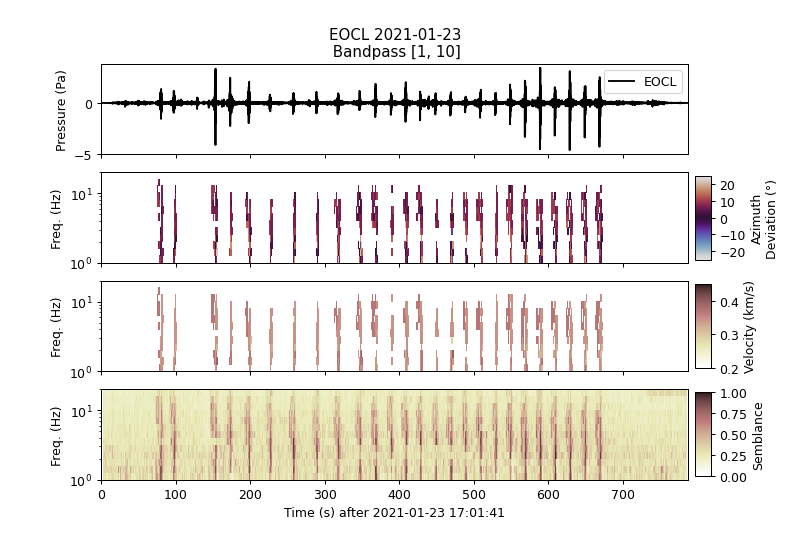

<IPython.core.display.Javascript object>


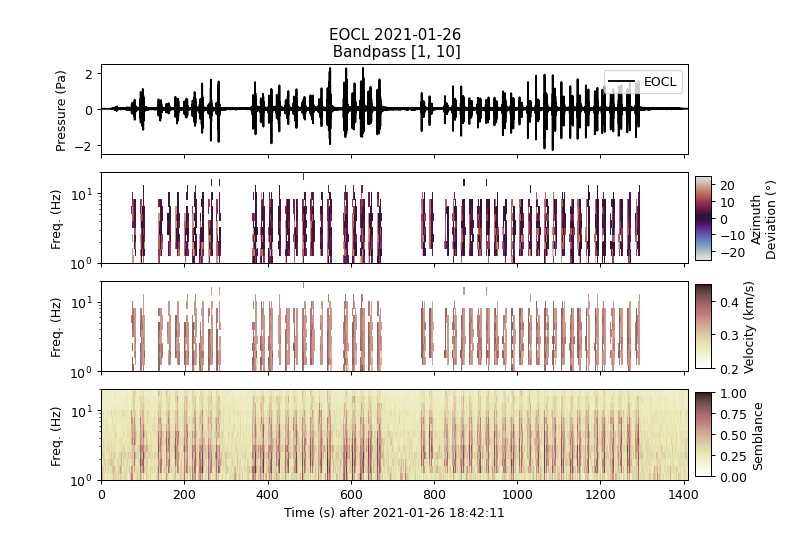

<IPython.core.display.Javascript object>


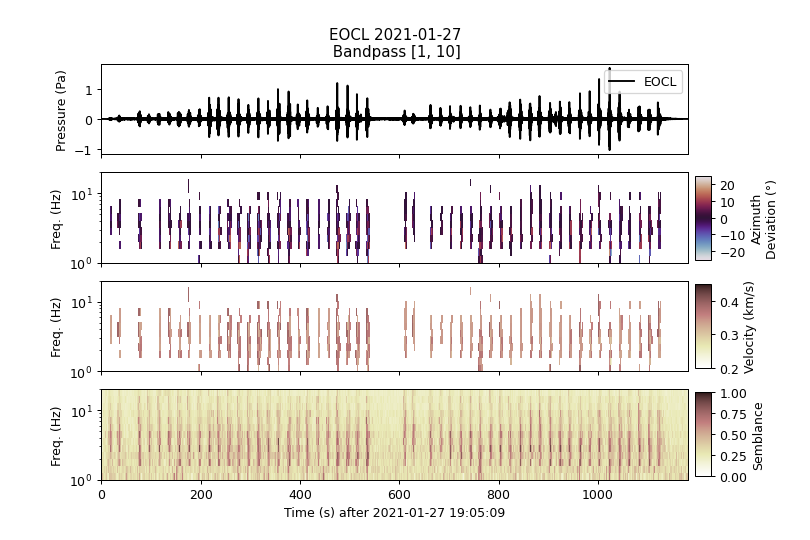

<IPython.core.display.Javascript object>


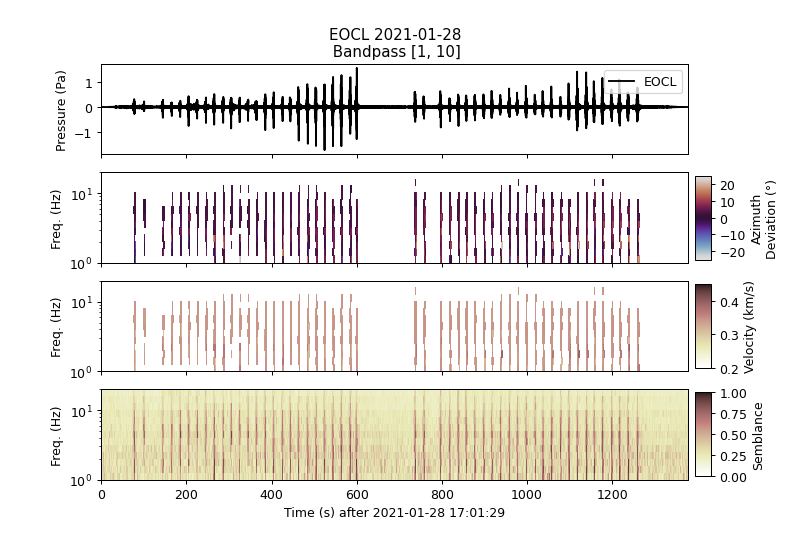

<IPython.core.display.Javascript object>


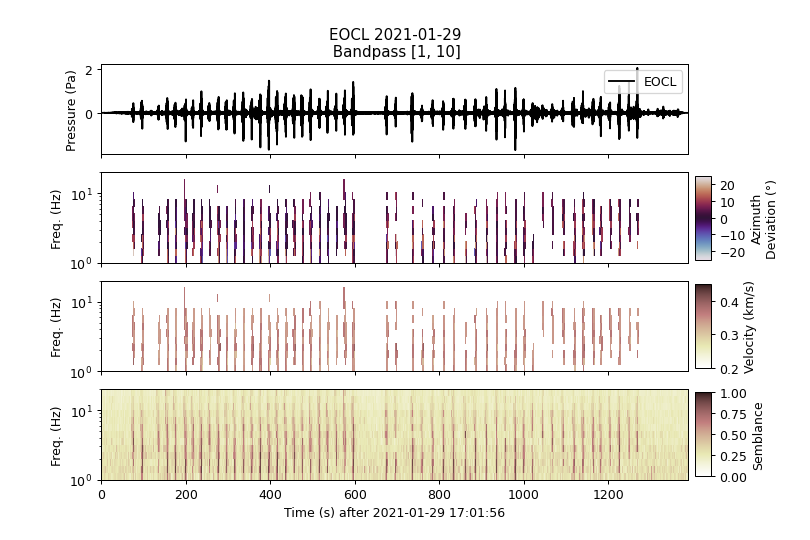

<IPython.core.display.Javascript object>


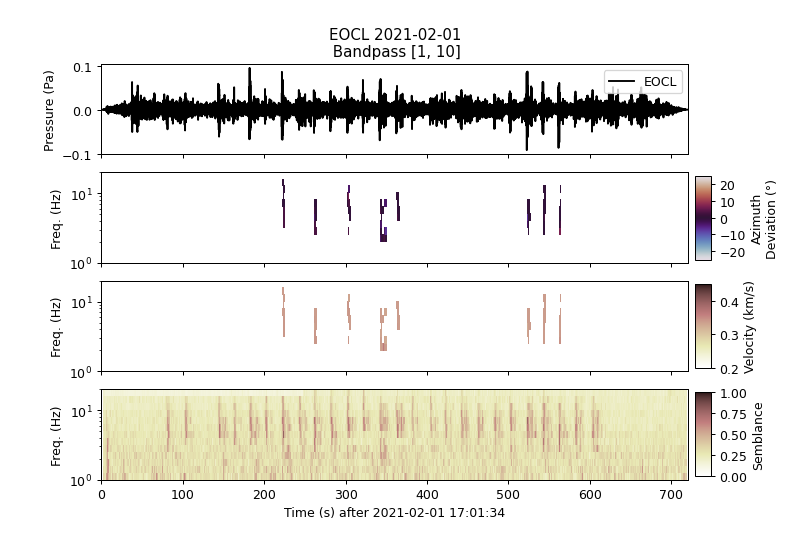

<IPython.core.display.Javascript object>


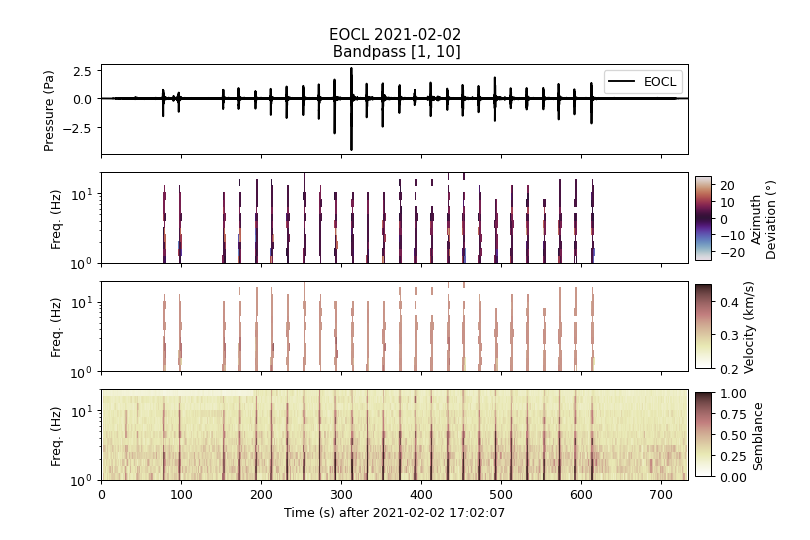

<IPython.core.display.Javascript object>


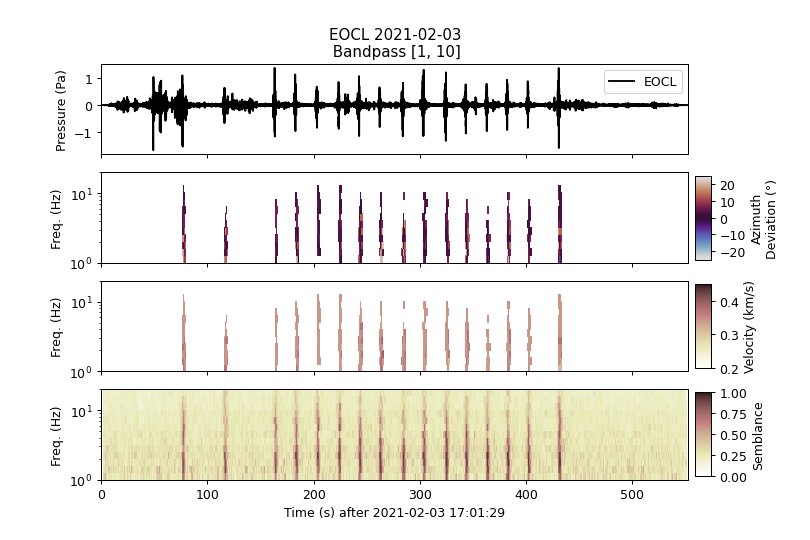

<IPython.core.display.Javascript object>


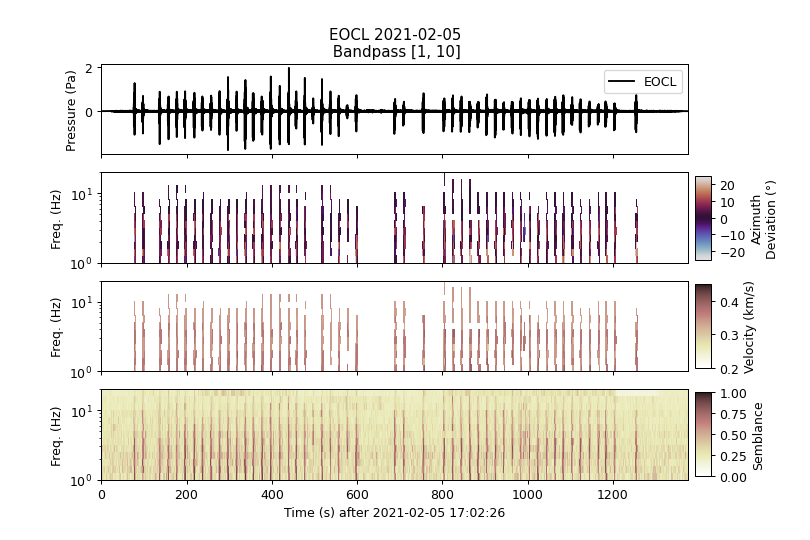

<IPython.core.display.Javascript object>


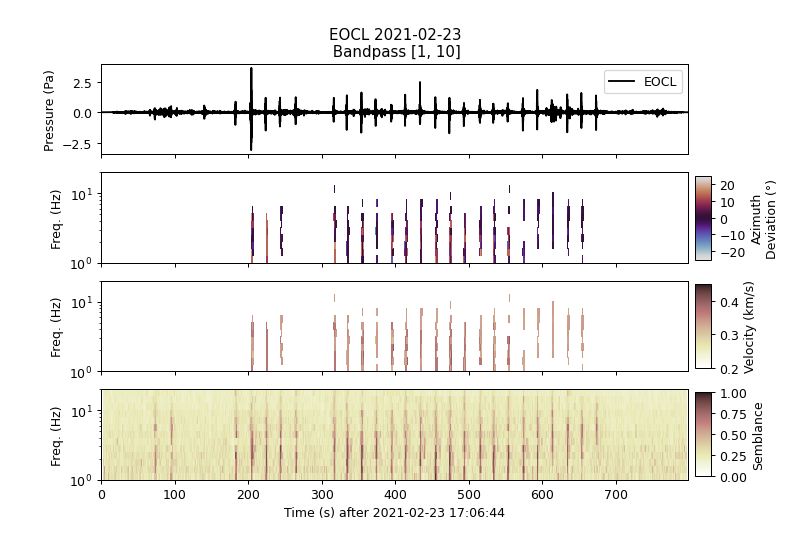

<IPython.core.display.Javascript object>


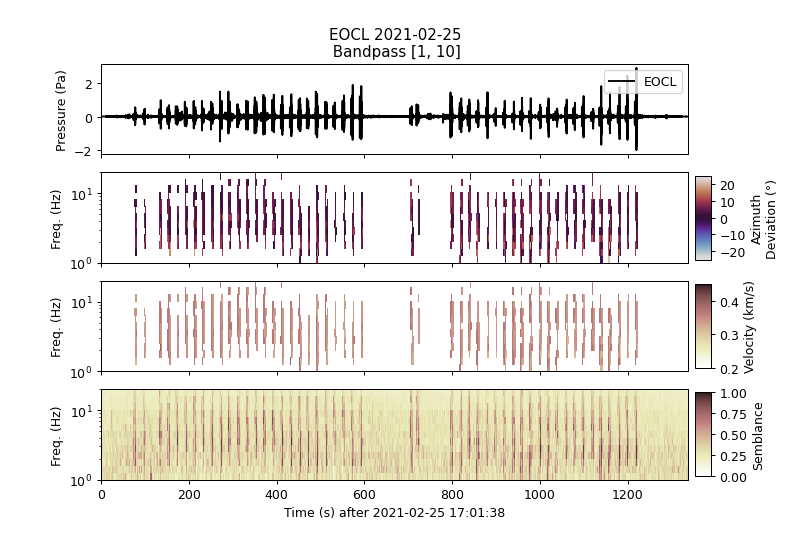

<IPython.core.display.Javascript object>


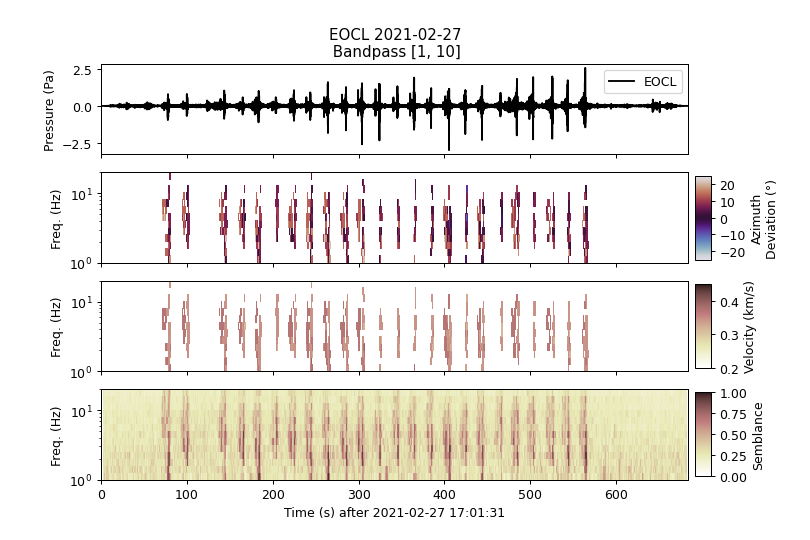

CPU times: user 1min 25s, sys: 49.6 s, total: 2min 14s
Wall time: 4min 45s


In [4]:
%%time
%matplotlib notebook
# Directory path to verified MCA detections
file_pattern = EOC_dir+'/MCA_Detections/Data/*.mseed'
# Geographic coordinates used for source and MCA array 
source_lon = -95.902050; source_lat = 34.802819; MCA_lon = -95.84248; MCA_lat = 34.83763
# Loop through each file and process EOCL array data
for MCA_filepath in glob.glob(file_pattern):
    st = Stream()
    day = MCA_filepath.split('/')[-1].split('_')[-1].split('.')[0]
    if day <= str(20): continue # no EOCL data for most on Jan 20 and before
    #-----------------------------------------------------------------------------------------------------------------------#
    # Read data
    st = mcaap.read_data(day=day, data_dir=EOC_dir, loc_dir=EOC_dir+'EOCL_HDF_Locations.txt', EOCL=True)
    st = st.resample(40).merge() # resampling to expedite processing time
    #-----------------------------------------------------------------------------------------------------------------------#
    # Calculating GT back azimuth for filtering array processing results
    _, GT_baz, dist = g.inv(source_lon, source_lat, st[0].stats.sac.stlo, st[0].stats.sac.stla) # using midpoint between areas 1 and 2
    if GT_baz < 0: GT_baz += 360
    #-----------------------------------------------------------------------------------------------------------------------#
    # Load MCA start times
    with open(EOC_dir+'MCA_Detections/Signal_Times_CWT/UTC_Starttimes/'+str(day)+'.txt', 'r') as f: # reference time (UTC)
        ref_time = UTCDateTime(f.read())
    with open(EOC_dir+'MCA_Detections/Signal_Times_CWT/MCA01_BDF/'+str(day)+'.npy', 'rb') as f: # only using central array element
        MCA_times = np.load(f)
    #-----------------------------------------------------------------------------------------------------------------------#
    # Calculate buffers for EOCL trim
    MCA_startTime = ref_time + MCA_times[0][0]; MCA_endTime = ref_time + MCA_times[0][-1] # onset of first/last signal at MCA center element
    _, _, dist = g.inv(MCA_lon, MCA_lat, st[0].stats.sac.stlo, st[0].stats.sac.stla); dist /= 1000 # distance b/w MCA and EOCL - converted to km
    start_buffer = dist / 0.750; end_buffer = dist / 0.180 # buffer using celerity
    startTrim = MCA_startTime + start_buffer; endTrim = MCA_endTime + end_buffer
    #-----------------------------------------------------------------------------------------------------------------------#
    # Trim stream
    st.trim(startTrim, endTrim)
    try:
        st.write(EOC_dir+'EOCL_Detections/Data/EOCL_'+str(day)+'.mseed', format='MSEED')
    except:
        st = st.split().copy()
        st.write(EOC_dir+'EOCL_Detections/Data/EOCL_'+str(day)+'.mseed', format='MSEED')
    #-----------------------------------------------------------------------------------------------------------------------#
    # Run Cardinal
    T, B, V, S = cardinal_v3.sliding_time_array_fk_multifreq(st, f_bands, adaptive_array=False, n_workers=12)
    #-----------------------------------------------------------------------------------------------------------------#
    # Creating families
    ref_time = st[0].stats.starttime.matplotlib_date
    ix, pixels_in_families, families = cardinal_v3.make_families(T, B, V, S, f_bands, ref_time,
                                                                 dist_threshold=1, min_pixels=25,
                                                                 sigma_b=5, sigma_f=5, sigma_t=5, semblance_threshold=0.5,
                                                                 GT_baz=GT_baz, baz_dev=25, expected_vel=0.25, vel_dev=0.15) # baz dev has to be a bit higher here (prob cuz 1D array)
    df = cardinal_v3.df_families(ref_time, families)
    df.to_csv(EOC_dir+'EOCL_Detections/Signal_Times/'+str(day)+'.csv', index=False)
    #-----------------------------------------------------------------------------------------------------------------#
    # Plot results
    cardinal_v3.plot_sliding_window_multifreq(st, st[0].stats.station, f_bands, T, B, V, S, semblance_threshold=0.5, clim_vtr=[0.2,0.45], clim_baz=[-25,25], log_freq=True, 
                                              plot_real_amplitude=True, amplitude_units='Pressure (Pa)',bandpass=[1,10], GT_baz=GT_baz, figsize=(9,6), 
                                              ix=ix, pixels_in_families=pixels_in_families, title='EOCL ' + str(st[0].stats.starttime).split('T')[0], 
                                              fname_plot=EOC_dir+'EOCL_Detections/Plots/'+str(day)+'.png')

 Increasing distance threshold decreases number of detections (it encompasses more signals)